In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class my_neural_network:
    
    def __init__(self, hidden_layer_plan):
        
        '''
        Initialization function.
        
        input: 
        layer_plan : data_type = list
        
        List cointaing the number of neurons in every layers for the neural network. The first and last elements of
        layer_plan corresponds to number of input features and the output value. 
        The rest of the elements between them corresponds to the neurons in hidden layers.
        More the Hidden Layers implies deeper the network!
        '''
        
        #dataset
        self.dataset = None
        
        #input and output data
        self.input_data = None
        self.output_data = None
        self.predicted_output =None
        
        #train and test data
        self.training_data = None
        self.testing_data = None
        
        #layer details
        self.hidden_layer_plan = hidden_layer_plan
        self.layer_dimensions = None
        self.num_of_layers = None
        
        #Batching
        self.mini_batches = []
        
        #Forward Activation
        self.activations, self.Z = [], []
        
        #Backward Activation
        self.dActivations = []
        
        #Error_method and loss
        self.error_method = None
        self.loss = None
        self.cost = []
        self.cost_value = None
        
        #Network parameters
        self.network_weights, self.gradient_weights,self.momentum_weights, self.rms_weights = [],[],[],[]
        self.network_bias, self.gradient_bias,self.momentum_bias, self.rms_bias = [],[],[],[]
        #optimizer
        self.optimizer = None
        
    def __repr__(self):
        ''' Representative function to welcome the user for collaborating with the new AI trainer'''
        return 'Hello there!! I am your new AI trainer......!'
    
    
    def load_dataset(self, file):
        ''' 
        To load dataset 
        
        input:
        file : data_type: string
        File name consisting the inputs and outputs. The last column in the file is the output.
        '''
        self.dataset = np.loadtxt(file)
        self.input_data = self.dataset[:,:-1]
        self.output_data = self.dataset[:,-1]
        
        #Normalization
        max_inputs = np.amax(self.input_data, axis=0)
        min_inputs = np.amin(self.input_data, axis=0)
        diff_inputs = max_inputs - min_inputs
        self.input_data = np.divide((self.input_data - min_inputs),diff_inputs)
        
        max_outputs = np.amax(self.output_data, axis=0)
        min_outputs = np.amin(self.output_data, axis=0)
        diff_outputs = max_outputs - min_outputs
        self.output_data = np.divide((self.output_data - min_outputs), diff_outputs)
        
        #Layer planning
        self.layer_dimensions = [self.input_data.shape[1]]+self.hidden_layer_plan+[1] #1 corresponds to columns in O/P
        self.num_of_layers = len(self.layer_dimensions)
        
    def test_train_split(self, split = 0.7):
        '''
        This function is utilized to segragate the complete data into training and testing data.
        '''
        
        n_total = int(self.dataset.shape[0])
        n_train = int(split*n_total)
        
        mask = np.zeros((n_total), dtype=bool)
        mask[:n_train] = True
        
        np.random.shuffle(mask)
        
        X_train = self.input_data[mask]
        Y_train = self.output_data[mask]
        
        X_test = self.input_data[~mask]
        Y_test = self.output_data[~mask]
        
        self.training_data = (X_train.transpose(), Y_train)
        self.testing_data = (X_test.transpose(), Y_test)
    
    def network_parameters_initialization(self):
        np.random.seed(1)
        for i in range(1,self.num_of_layers):
            self.network_weights.append(np.random.randn(self.layer_dimensions[i], 
                                                                         self.layer_dimensions[i-1]))
            self.network_bias.append(np.random.randn(self.layer_dimensions[i],1))
            
            assert(self.network_weights[i-1].shape == (self.layer_dimensions[i], 
                                                                         self.layer_dimensions[i-1]))
            assert(self.network_bias[i-1].shape == (self.layer_dimensions[i],1))
            
            self.gradient_weights.append(np.zeros_like(self.network_weights[i-1])) #np.zeros((self.layer_dimensions[i], self.layer_dimensions[i-1]))
                                                                         #
            self.gradient_bias.append(np.zeros_like(self.network_bias[i-1]))#np.zeros((self.layer_dimensions[i],1))
            
            self.momentum_weights.append(np.zeros_like(self.network_weights[i-1]))
            
            self.momentum_bias.append(np.zeros_like(self.network_bias[i-1]))
            
            self.rms_weights.append(np.zeros_like(self.network_weights[i-1]))
            
            self.rms_bias.append(np.zeros_like(self.network_bias[i-1]))
     
    def batching(self, batching = False, batch_size = None):
        '''
        The NN_gradient_descent function helps to build and get the deep network working. 
        
        inputs:
        learning_rate : floating number
        This is an hyper parameter which is used in gradient descent
        '''
        num_examples = self.training_data[0].shape[1]
              
        
        if batching:
            
            training_input = self.training_data[0]
            training_output = self.training_data[1]
            
            #mini_batches = []
            
            number_of_batches = int(num_examples/batch_size)
            
            for j in range(0,number_of_batches):
                mini_train_input = training_input[:,(j*batch_size):((j+1)*batch_size)]
                mini_train_output = training_output[:,(j*batch_size):((j+1)*batch_size)]
                self.mini_batches.append((mini_train_input,mini_train_output))
                
            if num_examples % batch_size != 0:
                mini_train_input = training_input[:,(number_of_batches*batch_size):]
                mini_train_output = training_output[:,(number_of_batches*batch_size):]
                self.mini_batches.append((mini_train_input,mini_train_output))
        else:
            
            self.mini_batches = [self.training_data]




    def sigmoid(self,Z):
        return 1/(1+np.exp(-Z))

    def sigmoid_derivative(self,Z):
        return self.sigmoid(Z)*(1-self.sigmoid(Z))

    def forward_propagation(self, X):
        self.activations = [X]
        for l in range(self.num_of_layers-1):

            Z = np.dot(self.network_weights[l], self.activations[l])+self.network_bias[l]

            activated_Z = self.sigmoid(Z)

            self.Z.append(Z)
            self.activations.append(activated_Z)

    def cost_function(self, error_method = 'MSE',test = False):
        self.error_method = error_method
        if test:
            y_o = self.testing_data[1]
        else:
            y_o = self.training_data[1]
        if error_method == 'MSE':
            cost = 0.5*np.mean(np.square(self.activations[-1] - y_o))
            self.cost_value = np.squeeze(cost)
        

    def cost_function_derivative(self, test=False):
        if test:
            y_o = self.testing_data[1]
        else:
            y_o = self.training_data[1]
            
        if self.error_method == 'MSE':
            delC_delA = self.activations[-1] - y_o

        self.loss = delC_delA

    def back_propagation(self,X,Y):
        
        delC_delA = self.loss

        #For Last Layer

        #delC _delZ = delC_delA * delA_delZ
        delC_delZ = delC_delA*self.sigmoid_derivative(self.Z[-1])
        #delC_delB =  delC_delA * delA_delZ * delZ_delB
        delC_delB = np.mean(delC_delZ, axis=1,keepdims = True)
        #delC_delW =  delC_delA * delA_delZ * delZ_delW
        delC_delW = (1.0/X.shape[1])*np.dot(delC_delZ,self.activations[-2].transpose())

        self.gradient_weights[-1] = delC_delW
        assert ( self.gradient_weights[-1].shape == self.network_weights[-1].shape)
        self.gradient_bias[-1] = delC_delB#.reshape(self.network_bias[-1].shape)
        #assert ( self.gradient_network_parameters['dbias'+str(self.num_of_layers-1)].shape == self.network_parameters['bias'+str(self.num_of_layers-1)].shape)

        for i in reversed(range(2,self.num_of_layers)):
            delC_delA = np.dot(self.network_weights[i-1].transpose(),delC_delZ)
            delC_delZ = delC_delA*self.sigmoid_derivative(self.Z[i-2])
            delC_delB = np.mean(delC_delZ, axis=1)
            delC_delW = (1.0/X.shape[1])*np.dot(delC_delZ,self.activations[i-2].transpose())

            self.gradient_weights[i-2] = delC_delW
            assert ( self.gradient_weights[i-2].shape == self.network_weights[i-2].shape)
            self.gradient_bias[i-2] = delC_delB.reshape(self.network_bias[i-2].shape)
            assert ( self.gradient_bias[i-2].shape == self.network_bias[i-2].shape)

    def update_parameters_GD(self,learning_rate):
            ''' Implementation of gradient descent method '''
            for p in range(1,self.num_of_layers):

                self.network_weights[p-1] -= learning_rate*self.gradient_weights[p-1]

                self.network_bias[p-1] -= learning_rate*self.gradient_bias[p-1]

    
    def update_parameters_Momentum(self,learning_rate,beta1):
        '''Implementation of Steepest Gradient descent Method'''
        
        for p in range(1,self.num_of_layers):
            
            self.momentum_weights[p-1] = beta1*self.momentum_weights[p-1] + (1-beta1)*self.gradient_weights[p-1]
            self.momentum_bias[p-1] = beta1*self.momentum_bias[p-1] + (1-beta1)*self.gradient_bias[p-1]
            
            self.network_weights[p-1] -= learning_rate*self.momentum_weights[p-1]
            self.network_bias[p-1] -= learning_rate*self.momentum_bias[p-1]
            
    def update_parameters_RMSProp(self, learning_rate,beta2,epsilon=1e-8):
        ''' Implementation of RMS Prop optimization'''
        
        for p in range(1,self.num_of_layers):
            
            self.rms_weights[p-1]= beta2*self.rms_weights[p-1] + (1-beta2)*(self.gradient_weights[p-1])**2
            self.rms_bias[p-1] = beta2*self.rms_bias[p-1] + (1-beta2)*(self.gradient_bias[p-1])**2
            
            self.network_weights[p-1] -= (learning_rate*self.gradient_weights[p-1])/(np.sqrt(self.rms_weights[p-1])+epsilon)
            self.network_bias[p-1] -= (learning_rate*self.gradient_bias[p-1])/(np.sqrt(self.rms_bias[p-1])+epsilon)
        
    def update_parameters_Adam(self,learning_rate,beta1, beta2, epsilon=1e-8):
        '''Implementation of Adaptive Moment Estimation(Adam) optimization'''
        
        temp_momentum_weights, temp_momentum_bias, temp_rms_weights, temp_rms_bias = [],[],[],[]
        
        for p in range(1,self.num_of_layers):
            
            self.momentum_weights[p-1] = beta1*self.momentum_weights[p-1] + (1-beta1)*self.gradient_weights[p-1]
            self.momentum_bias[p-1] = beta1*self.momentum_bias[p-1] + (1-beta1)*self.gradient_bias[p-1]
            
            temp_momentum_weights.append(self.momentum_weights[p-1]/(1-beta1**p))
            temp_momentum_bias.append(self.momentum_bias[p-1]/(1-beta1**(p)))
            
            self.rms_weights[p-1]= beta2*self.rms_weights[p-1] + (1-beta2)*(self.gradient_weights[p-1])**2
            self.rms_bias[p-1] = beta2*self.rms_bias[p-1] + (1-beta2)*(self.gradient_bias[p-1])**2
            
            temp_rms_weights.append(self.rms_weights[p-1]/(1-beta2**p))
            temp_rms_bias.append(self.rms_bias[p-1]/(1-beta2**p))
            
            self.network_weights[p-1] -= (learning_rate*temp_momentum_weights[p-1])/(np.sqrt(temp_rms_weights[p-1])+epsilon)
            self.network_bias[p-1] -= (learning_rate*temp_momentum_bias[p-1])/(np.sqrt(temp_rms_bias[p-1])+epsilon)
        
    def NN_model(self, epochs, learning_rate, beta1=None, beta2=None, batching=False, batch_size = None,  error_method = 'MSE', optimizer='GD'):
        
        ''' Deep neural network model'''
        
        self.network_parameters_initialization()
        self.optimizer = optimizer
        
        for iteration in range(epochs):
            
            #Batching
            self.batching(batching=False, batch_size=None)
            
            #Traversing through Mini Batches:
            for mini_batch in self.mini_batches:
                
                mini_batch_X, mini_batch_Y = mini_batch
                
                #Forward Prop
                self.forward_propagation(mini_batch_X)
                
                #Loss calculation
                self.cost_function(error_method)
                self.cost_function_derivative()

                if iteration%(epochs/10) == 0:
                    self.cost.append(np.squeeze(self.cost_value))#np.mean(self.loss)))
                    print('The cost after iteration: ', iteration, 'is :', self.cost_value)#np.squeeze(np.mean(self.loss)))
                #Back Prop
                self.back_propagation(mini_batch_X,mini_batch_Y)
                
                if self.optimizer == 'GD':
                    #Updating parameters with Gradient Descent
                    self.update_parameters_GD(learning_rate)
                
                elif self.optimizer == 'Momentum':
                    #Updating parameters with Steepest Gradient
                    self.update_parameters_Momentum(learning_rate, beta1)
                    
                elif self.optimizer == 'RMSProp':
                    self.update_parameters_RMSProp(learning_rate, beta2)
                    
                elif self.optimizer == 'adam':
                    #Updating parameters with Adam optimization
                    self.update_parameters_Adam(learning_rate, beta1, beta2)
                    
                
    
                
        #prediction
        prediction_train = self.training_data[0]
        self.forward_propagation(prediction_train)
        
        #Evaluation
        self.evaluate()
        
        
    def evaluate(self):
        prediction_test = self.testing_data[0]
        self.forward_propagation(prediction_test)
        
        self.cost_function(self.error_method, test=True)
        print('The cost in Testing is: ', self.cost_value)

#import numpy as np
data = np.loadtxt('log.txt')
data1 = np.zeros((data.shape[0],2))

In [3]:
#def NN_model(self, epochs, learning_rate, beta1 , batching=False, batch_size = None,  error_method = 'MSE', optimizer='GD')
hidden_layer_dims = [15,15]
model = my_neural_network(hidden_layer_dims)
file_name = 'log.txt'
model.load_dataset(file_name)
model.test_train_split()
model.NN_model(1000, 0.009,beta1=0.6,beta2=0.62, batching = True, batch_size= 64,optimizer = 'adam')

The cost after iteration:  0 is : 0.14266891725119998
The cost after iteration:  100 is : 0.04246160490147096
The cost after iteration:  200 is : 0.014183281431226423
The cost after iteration:  300 is : 0.008998652003797902
The cost after iteration:  400 is : 0.005864217971799831
The cost after iteration:  500 is : 0.0031792833579427425
The cost after iteration:  600 is : 0.002550131877215925
The cost after iteration:  700 is : 0.0021053287289726145
The cost after iteration:  800 is : 0.0018409270581624033
The cost after iteration:  900 is : 0.001693576320987928
The cost in Testing is:  0.001928479589942299


## Cost Function

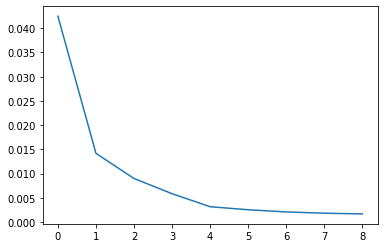

In [4]:
plt.plot(np.array(model.cost[1:]))
plt.show()

## Plotting testing output v/s predicted output

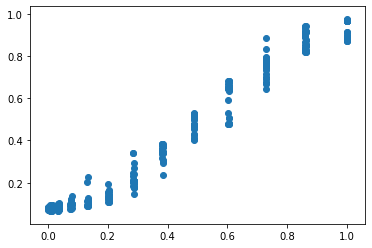

In [5]:
plt.scatter(model.testing_data[1],model.activations[-1].reshape(model.testing_data[1].shape))
plt.show()

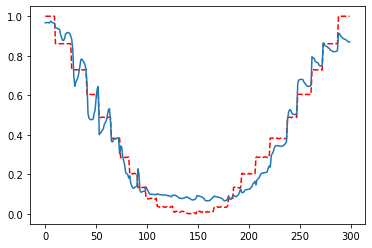

In [6]:
plt.plot(model.testing_data[1], 'r--')
plt.plot(model.activations[-1].reshape(model.testing_data[1].shape))

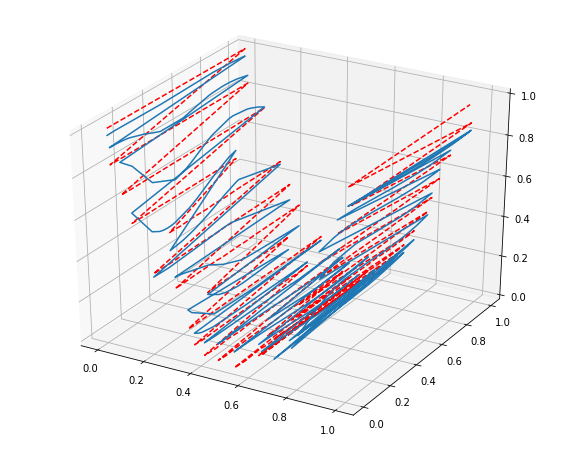

In [8]:
from mpl_toolkits import mplot3d
X = model.testing_data[0]
X1 = X[0,:]
X2 = X[1,:]
fig1 = plt.figure(figsize=(10,8))
ax1 = plt.axes(projection='3d')
ax1.plot3D(X1,X2,model.testing_data[1], 'r--')
Y = model.activations[-1].reshape(model.testing_data[1].shape)
ax1.plot3D(X1,X2,Y)#, 'r--')
#X1.shape, X2.shape,model.testing_data[1].shape